# **데이터 준비**

## **다운로드**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **살펴보기**

In [ ]:
# 모듈 import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns
import cv2


# 이미지 처리에 필요한 모듈 준비하기
import os
import glob

In [ ]:
# IMAGE 불러오기 import

from PIL import Image
import matplotlib.pylab as plt

In [ ]:
# 연습
path = '/content/drive/MyDrive/AI 감정인식 프로젝트/Final/datasets2' 


path_angry = path+ '/angry'


angry = glob.glob(path_angry+ '/*')

print('angry 이미지 개수: {}'.format(len(angry))) # 곧 주석.. angry는 2531개

#for i in range(len(angry)):
#  angry[i]




angry 이미지 개수: 2531


In [ ]:
feeling_images = [] #감정이 labeling 된 data 전체가 담길 빈 리스트

def put_label(feeling,emotion):
  
  for i in range(len(feeling)):

    filename = str(feeling[i]).split('/')[-1] # /로 구분 -> 제일 마지막 부분(파일 이름만 가져오기)
    filename = filename.replace('.jpg','') # filename에서 '.jpg'(확장자) 날려주기 -> 파일의 순수한 이름

    pixels = convertingPixel(feeling, i) # 픽셀로 뽑아내기

    feeling_images.append([str(emotion), pixels, filename])  # 매개변수로 넘어오는 감정을 label로 같이 저장


def convertingPixel(feeling, num):
  r = Image.open(feeling[num])
  temp = ""
  for i in range(0, r.size[0]): # x방향 탐색
    for j in range(0, r.size[1]): # y방향 탐색
      rgb = r.getpixel((i,j))  # i,j 위치에서의 RGB 취득
      temp += str(rgb) + " "
  return temp.strip()

#print(temp)

In [ ]:
put_label(angry,'angry')

''' #주석
put_label(disgust,'disgust')
put_label(fear,'fear')
put_label(happy,'happy')
put_label(neutral,'neutral')
put_label(sad,'sad')
put_label(surprise,'surprise') '''

" #주석\nput_label(disgust,'disgust')\nput_label(fear,'fear')\nput_label(happy,'happy')\nput_label(neutral,'neutral')\nput_label(sad,'sad')\nput_label(surprise,'surprise') "

In [ ]:
# Dataframe으로 만들기
colnames = ['emotion', 'pixels', 'file_name']


feelings_df= pd.DataFrame(feeling_images,columns = colnames)
feelings_df

,emotion,pixels,file_name
0,angry,106 108 108 108 108 109 109 110 110 111 103 95...,angry_2081
1,angry,64 50 34 30 25 13 14 8 4 5 13 22 0 4 0 1 0 0 4...,angry_1663
2,angry,36 38 35 29 26 26 27 30 35 37 38 37 35 42 37 5...,angry_1659
3,angry,244 245 247 248 248 248 249 249 250 251 251 25...,angry_1719
4,angry,75 69 68 69 72 82 102 129 141 151 150 145 131 ...,angry_1997
...,...,...,...
2526,angry,26 30 32 31 30 29 28 28 30 18 13 7 6 16 25 29 ...,angry_818
2527,angry,116 138 129 125 118 80 59 65 66 64 63 70 74 58...,angry_536
2528,angry,120 127 131 125 117 113 111 108 108 104 100 10...,angry_843
2529,angry,230 231 232 232 232 233 232 231 232 233 231 23...,angry_816


In [ ]:
image_size=(48,48)


In [ ]:
pixels = feelings_df['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))
  
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

(2531, 48, 48, 1)


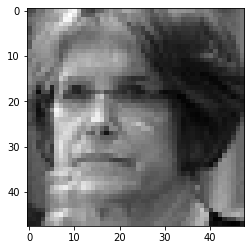

In [ ]:
plt.imshow(np.rot90(faces[0].squeeze(), k=-1), cmap="gray") #90도 회전 후 보여주기
#plt.imshow(faces[0].squeeze(), cmap="gray")


## **Normalization**

In [ ]:
print(np.min(faces), np.max(faces))
faces = faces / 255.0
print(np.min(faces), np.max(faces))

0.0 255.0
0.0 1.0


## **emotion 데이터 구하기**

In [ ]:
emotions = feelings_df['emotion'].values
print(emotions.shape)
print(emotions)

(2531,)
['angry' 'angry' 'angry' ... 'angry' 'angry' 'angry']


## **데이터 나누기**

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(faces, emotions, test_size=0.2)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2024, 48, 48, 1)
(2024,)
(507, 48, 48, 1)
(507,)


## **모델 정의**

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


model = models.Sequential()

model.add(Input(train_x.shape[1:]))
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])

## **데이터 증강**

In [ ]:
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
)

test_data_generator = ImageDataGenerator()

## **학습**

## **평가**

## **결과 보기**